# Deep Learning &mdash; Assignment 6

Sixth assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_October 2020_

-----

**Names:** Ward Theunisse & Nienke Wessel

**Group:** 25

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Build a variational auto encoder
2. Extend the model to a conditional VAE


## Required software

As before you will need these libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

## 6.1 MNIST dataset

In this assignment we will use the MNIST digit dataset. This dataset consists of 28×28 binary images and has 60000 training examples divded over 10 classes.

In [2]:
opts = {'batch_size':32, 'shuffle':True}
train_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    **opts)
test_iter = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    **opts)
num_classes = 10

**Run the code to load the MNIST dataset.**

## 6.2 Variational Auto Encoder


We will implement a Variational Auto Encoder. This model consists of two networks, an encoder and a decoder.
The encoder produces a distribution in the latent space, represented as the parameters of a normal distribution. The decoder takes the latent space representation and produces an output in the data space.

**Complete the implementation below**

In [47]:
class VAE(nn.Module):
    def __init__(self, latent_size=2):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        self.encoder_part1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)
        
        # Components of the decoder
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # DONE: Choose an appropriate activation function for the final layer.
            nn.Sigmoid() # A google search said this is an often chosen activation function...
        )

    def encode(self, x):
        h = self.encoder_part1(x)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # DONE: turn the sample ε from N(0,1) into a sample from N(μ,σ)
        return (eps*std_z)+mean_z

    def decode(self, z):
        h = self.decoder_part1_z(z)
        h = torch.reshape(h, (-1,64,7,7)) # Unflatten
        return self.decoder_part2(h)

    def forward(self, x):
        mean_z, logvar_z = self.encode(x)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z), mean_z, logvar_z

The encoder produces two outputs that together give the parameters of a normal distribution: mean and logvar, so $\mu$ and $\log(\sigma^2)$. The latter might seem strange, but there is a good reason for it.  
**What can go wrong if the decoder network directly outputs σ?**

$\sigma$ might become very small, and we might therefore lose numerical stability. 

## 6.3 Loss function

The loss for a variational autoencoder consists of two parts:
1. The reconstruction loss, which is the log likelihood of the data,
$L_\text{R} = P(x\mid z)$.
2. The Kulback-Leibler divergence from the encoder output to the target distribution,
$L_\text{KL}= KL(Q(z)\| P(z))$.

In our case the data is binary, so we use binary cross entropy for the reconstruction loss.

The derivation of the KL loss term can be found in appendix B of the VAE paper; [Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014](https://arxiv.org/pdf/1312.6114.pdf)

**Implement the KL loss term below**

In [20]:
def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

def kl_loss(mean_z, logvar_z):
    # DONE: your code here
    return -0.5 * torch.sum(1 + logvar_z - mean_z ** 2 - torch.exp(logvar_z))

def loss_function(recon_x, x, mean_z, logvar_z):
    l_r = reconstruction_loss(recon_x, x)
    l_kl = kl_loss(mean_z, logvar_z)
    return l_r + l_kl, l_r, l_kl

## 6.4 Training our VAE

**Complete the training loop below**

In [26]:
def train(model, num_epochs = 10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'test loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device)
            optimizer.zero_grad()
            # DONE: compute the outputs and loss
            recon_x, mean_z, logvar_z = model.forward(X)
            loss = loss_function(recon_x, X, mean_z, logvar_z)
            '''
            for l in loss:
                print(l.size())
                print(l)
                print()
            return
            #'''
            loss, loss_r, loss_kl = loss
            # Optimize
            loss.backward()
            optimizer.step()
            # Track our progress
            metric.add(loss_r, loss_kl, X.shape[0])
            train_loss_r  = metric[0] / metric[2]
            train_loss_kl = metric[1] / metric[2]
            train_loss = train_loss_r + train_loss_kl
            if i > 0 and i % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, None))
        test_loss_r, test_loss_kl = test(model)
        test_loss = test_loss_r + test_loss_kl
        animator.add(epoch+1, (None, test_loss))
    print(f'training loss {train_loss:.3f}, test loss {test_loss:.3f}')
    print(f'training reconstruction loss {train_loss_r:.3f}, test reconstruction loss {test_loss_r:.3f}')
    print(f'training KL loss {train_loss_kl:.3f}, test KL loss {test_loss_kl:.3f}')


def test(model):
    model.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for i, (X, y) in enumerate(test_iter):
            X = X.to(device)
            recon_x, mean_z, logvar_z = model(X)
            loss, loss_r, loss_kl = loss_function(recon_x, X, mean_z, logvar_z)
            metric.add(loss_r, loss_kl, X.shape[0])
    test_loss_r  = metric[0] / metric[2]
    test_loss_kl = metric[1] / metric[2]
    return test_loss_r, test_loss_kl

**Train the model**

training loss 154.798, test loss 154.780
training reconstruction loss 148.716, test reconstruction loss 148.772
training KL loss 6.082, test KL loss 6.008


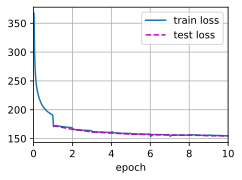

In [27]:
device = d2l.try_gpu()
model = VAE().to(device)
train(model)

**If you increase the numer of latent dimensions, how does that affect the reconstruction loss and the KL loss terms?**

training loss 157.269, test loss 156.784
training reconstruction loss 151.280, test reconstruction loss 150.861
training KL loss 5.989, test KL loss 5.923


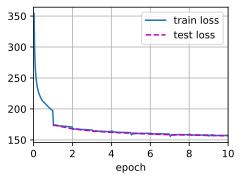

In [28]:
model = VAE(latent_size=3).to(device)
train(model)

training loss 179.578, test loss 178.157
training reconstruction loss 176.535, test reconstruction loss 175.049
training KL loss 3.042, test KL loss 3.108


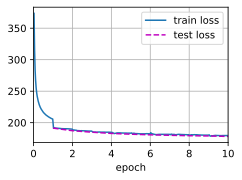

In [29]:
model = VAE(latent_size=4).to(device)
train(model)

training loss 132.248, test loss 132.502
training reconstruction loss 122.415, test reconstruction loss 122.869
training KL loss 9.833, test KL loss 9.633


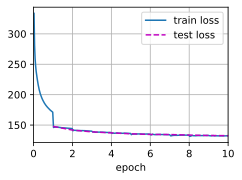

In [32]:
model = VAE(latent_size=6).to(device)
train(model)

training loss 141.667, test loss 141.537
training reconstruction loss 133.732, test reconstruction loss 133.595
training KL loss 7.935, test KL loss 7.943


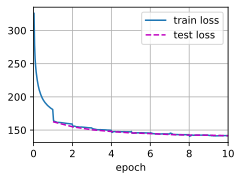

In [33]:
model = VAE(latent_size=8).to(device)
train(model)

Having tested out a bunch of different latent sizes, it's hard to describe a single trend, as KL-loss first becomes lower with recon loss becoming significantly higher, after which the KL-loss becomes higher, and recon loss becomes somewhat lower than it was initially.

## 6.5 Visualizing the latent space

We can use the function below to visualize the 2D latent space, by running the decoder on $z$ values sampled at regular intervals.

**Complete the code below and run it to plot the latent space.**

training loss 157.166, test loss 157.254
training reconstruction loss 151.453, test reconstruction loss 151.512
training KL loss 5.713, test KL loss 5.742


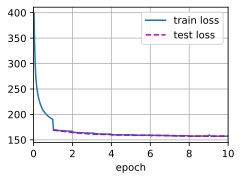

In [36]:
model = VAE().to(device)
train(model)

(30,)


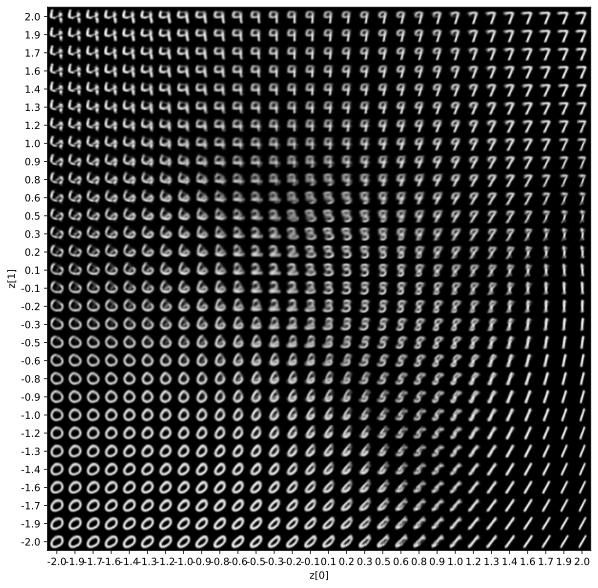

In [60]:
def plot_latent(model):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # TODO: run the decoder on z = [xi,yi].
            z = [xi, yi]
            z = torch.tensor(z, dtype=torch.float)
            z.to(device)
            x_decoded = model.decode(z)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded.detach().cpu().numpy()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)[:-1]
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(model)

**Would it be possible to classify digits based on this latent representation?**

Seems quite likely! For each class there seems to be a somewhat identifiable corresponding region in the latent space.

**If you retrain the model, would you expect the latent space to look the same. If not, what differences can you expect?**

No, not necessarily. Since network weights are initialized randomly, we may as well find another local optimum. A trivial example of another latent space with the same loss would be one in which a dimension is inverted or swapped with another dimension.

Another way of visualizing the latent space is by making a scatter plot of the training data in the latent space.

**Complete and run the code below to make a scatterplot of the training data**

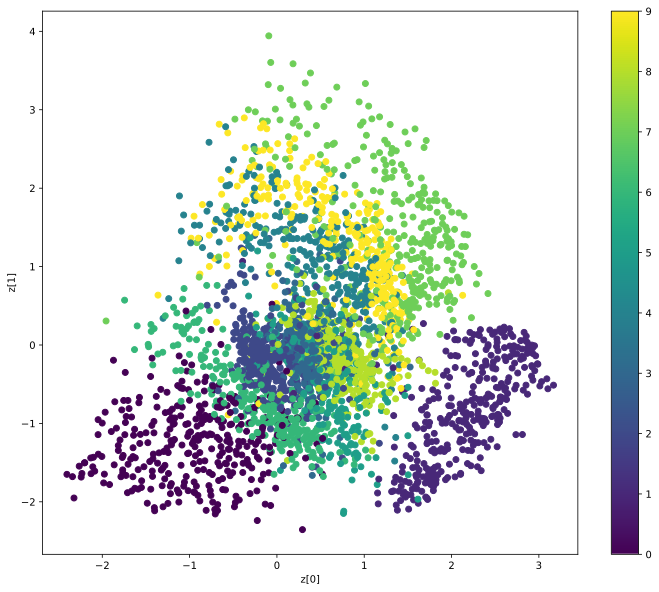

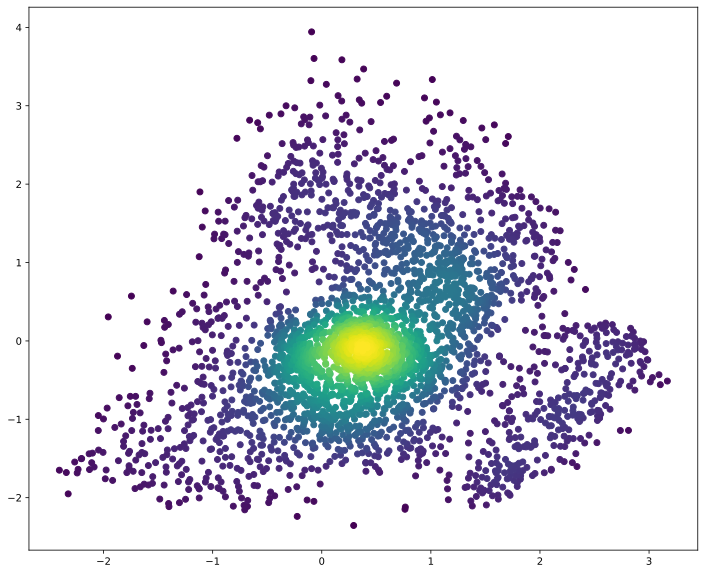

In [63]:
from scipy.stats import gaussian_kde

def scatterplot_latent(model):
    # display a 2D plot of the digit classes in the latent space
    zs, ys = [], []
    for i, (X, y) in enumerate(train_iter):
        if i > 100: # Limit to a few batches to save memory
            break
        # DONE: compute mean z
        z_mean, _ = model.encode(X)
        zs.append(z_mean.detach().cpu())
        ys.append(y)
    zs = torch.cat(zs).numpy()
    ys = torch.cat(ys).numpy()
    
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=ys)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
    # We've added a density scatter plot:
    xy = np.vstack([zs[:, 0],zs[:, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0][idx], zs[:, 1][idx], c=z[idx])

scatterplot_latent(model)

**Compare this figure to the previous one, what do you notice?**

Class separation is a lot less apparent here. It is not a nice continuum like the latent space itself.

**Look at the distribution of the data in the latent space. What distribution do you expect it to have based on the theory? Does the plot match this?**

We would expect it to have a shape similar to a 2d gaussian. We've added a scatterplot that shows the point density, and that seems to match what we would expect for a 2d gaussian, even if the general outline isn't nicely ovoid.

## 6.6 Conditional Variational Autoencoder

An extension of variational autoencoders uses labels to *condition* the encoder and decoder models.
In this conditional VAE, the decoder becomes $P(x|z,y)$ and the encoder $Q(z|x,y)$.
In practice this means that the label $y$ is given as an extra input to the both the encoder and the decoder.

For details see the paper [Semi-Supervised Learning with Deep Generative Models; Kingma, Rezende, Mohamed, Welling; 2014](https://arxiv.org/pdf/1406.5298.pdf).

To use the labels in the decoder, we can concatenate the label with the latent vector. Or equivalently, we can use separate weights for $z$ and $y$ in the first layer, so that layer computes $W_z * z + W_y * y + b$.

Similarly for the encoder, except there we will still use a convolutional layer for $x$, combined with a fully connected layer for $y$.

**Complete the implementation of the conditional VAE below**

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_size=2, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_size = latent_size

        # Components of the encoder network
        # TODO: split the first layer from the previous encoder network into a separate variable,
        #       and add a layer to use with the y input
        self.encoder_part1_x = ...
        self.encoder_part1_y = ...
        self.encoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 16), nn.ReLU()
        )
        self.encoder_mean   = nn.Linear(16, latent_size)
        self.encoder_logvar = nn.Linear(16, latent_size)

        # Components of the decoder network
        self.decoder_part1_z = nn.Linear(latent_size, 7*7*64)
        # TODO: add layer to use with the y input
        self.decoder_part2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, output_padding=1, stride=2),
            # TODO: see VAE
        )

    def encode(self, x, y):
        h = self.encoder_part1_x(x) + self.encoder_part1_y(y).reshape(-1,32,14,14)
        h = self.encoder_part2(h)
        return self.encoder_mean(h), self.encoder_logvar(h)

    def sample_latent(self, mean_z, logvar_z):
        std_z = torch.exp(0.5*logvar_z)
        eps = torch.randn_like(std_z)
        # TODO: see VAE

    def decode(self, z, y):
        # TODO: use a first layer that combines z and y
        h = ...
        h = torch.reshape(h, (-1,64,7,7))
        return self.decoder_part2(h)

    def forward(self, x, y):
        mean_z, logvar_z = self.encode(x, y)
        z = self.sample_latent(mean_z, logvar_z)
        return self.decode(z, y), mean_z, logvar_z

**Copy the training code from section 6.4, and modify it for a conditional VAE**

Hint: To train the conditional VAE we need to use one-hot encoding of the labels. You can use the following code for that:

    y = F.one_hot(y,10).float().to(device)

In [ ]:
# TODO: your code here


**Train a conditional VAE**

In [ ]:
cvae_model = ConditionalVAE().to(device)
train_cvae(cvae_model)

**Adapt the `plot_latent` function from section 6.5 for conditional VAEs and use your function to visualize the latent space for a few classes.**

In [ ]:
# TODO: your code here


**What do the latent dimensions represent? Is this the same for all labels?**

TODO: your answer here

**Adapt `scatterplot_latent` to show the distribution in the latent space.**

**How is this distribution different from the distribution of the VAE? Does this match the theory?**

TODO: your answer here

**Would it be possible to classify digits based on the latent representation of the conditional VAE?**

TODO: your answer here

**How would you use a conditional VAE to change the label of an image, while keeping everything else as similar as possible?**

TODO: your answer here

## 6.7 Discussion

**Is the conditional VAE a strict improvement over the normal VAE in all cases?**

TODO: your answer here

**Compare the latent representation vector $z$ in the VAE with the input for the generator in a GAN. Are they the same thing?**

TODO: your answer here

## The end

Well done! Please double check the instructions at the top before you submit your results.